In [12]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
from evaluate import load
import pandas as pd
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

file_path = "combined_all_news.csv"  
df = pd.read_csv(file_path)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['İçerik Stemmed'].tolist(),
    df['Sentiment_Label'].tolist(),
    test_size=0.2
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': torch.tensor(train_labels, dtype=torch.long)
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': torch.tensor(val_labels, dtype=torch.long)
})

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(set(df['Sentiment_Label']))  
)

model.config.problem_type = "single_label_classification"

metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    labels = torch.tensor(labels).numpy()  
    precision = precision_score(labels, predictions, average="weighted", zero_division=0)
    recall = recall_score(labels, predictions, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")
    try:
        auc = roc_auc_score(labels, logits, multi_class="ovr")
    except ValueError:
        auc = float('nan')  
    cm = confusion_matrix(labels, predictions)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if len(cm) > 1 else 0
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if len(cm) > 1 else 0
    return {
        "accuracy": metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "sensitivity": sensitivity,
        "specificity": specificity
    }

training_args = TrainingArguments(
    output_dir="./results",                
    evaluation_strategy="epoch",         
    per_device_train_batch_size=8,        
    per_device_eval_batch_size=8,
    learning_rate=5e-5,                  
    num_train_epochs=2,                  
    weight_decay=0.01,                    
    save_strategy="epoch",              
    logging_strategy="epoch",           
    fp16=True                             
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  
)

trainer.train()

model.save_pretrained("bert_model")
tokenizer.save_pretrained("bert_model")
print("Model ve tokenizer başarıyla kaydedildi!")

eval_results = trainer.evaluate()
print(f"Değerlendirme Sonuçları:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

val_logits = trainer.predict(val_dataset).predictions
val_predictions = torch.argmax(torch.tensor(val_logits), dim=-1).numpy()

val_df = pd.DataFrame({
    "Text": val_texts,
    "Actual Sentiment": val_labels,
    "Predicted Sentiment": val_predictions
})

val_df.to_csv("predictions.csv", index=False)
print("Tahminler 'predictions.csv' dosyasına kaydedildi.")

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\musta\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\musta\AppData\Local\Temp\ipykernel_21108\3519833345.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Sensitivity,Specificity
1,0.235600,0.194038,0.950392,0.954338,0.950392,0.950453,nan,0.937143,1.000000
2,0.143900,0.167146,0.962794,0.962954,0.962794,0.962407,nan,0.940701,1.000000


Model ve tokenizer başarıyla kaydedildi!


Değerlendirme Sonuçları:
eval_loss: 0.1671459674835205
eval_accuracy: 0.9627937336814621
eval_precision: 0.962954366689796
eval_recall: 0.9627937336814621
eval_f1: 0.9624068016075086
eval_auc: nan
eval_sensitivity: 0.9407008086253369
eval_specificity: 1.0
eval_runtime: 4.0984
eval_samples_per_second: 373.806
eval_steps_per_second: 46.848
epoch: 2.0
Tahminler 'predictions.csv' dosyasına kaydedildi.


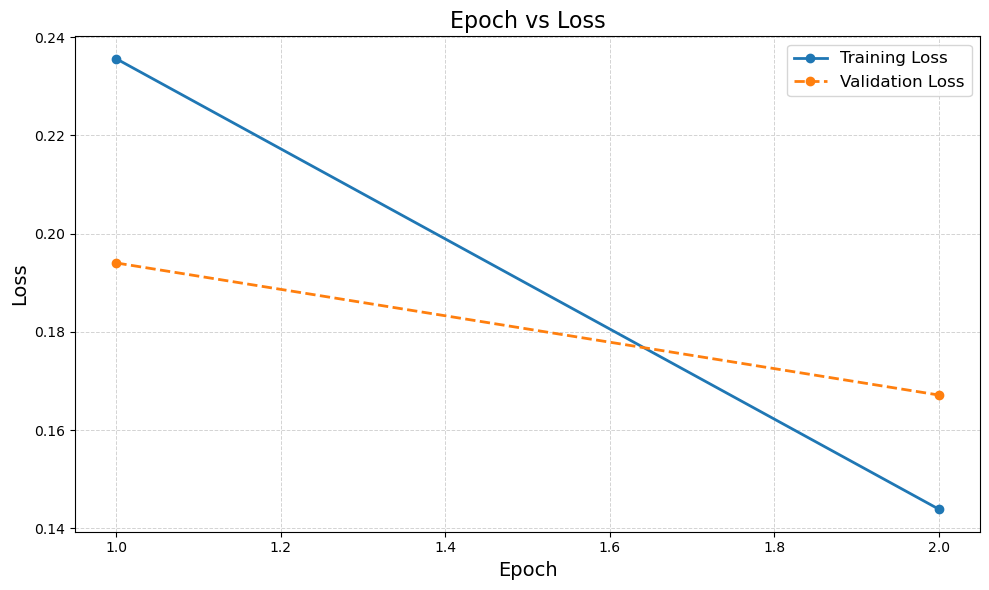

In [22]:
import matplotlib.pyplot as plt

training_logs = trainer.state.log_history

epochs = []
train_losses = []
eval_losses = []

for log in training_logs:
    if "epoch" in log:
        epochs.append(log["epoch"])
    if "loss" in log:  
        train_losses.append(log["loss"])
    if "eval_loss" in log:  
        eval_losses.append(log["eval_loss"])

min_length = min(len(train_losses), len(eval_losses))
train_losses = train_losses[:min_length]
eval_losses = eval_losses[:min_length]
epochs = range(1, min_length + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker='o', linestyle='-', linewidth=2)
plt.plot(epochs, eval_losses, label="Validation Loss", marker='o', linestyle='--', linewidth=2)

plt.title("Epoch vs Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

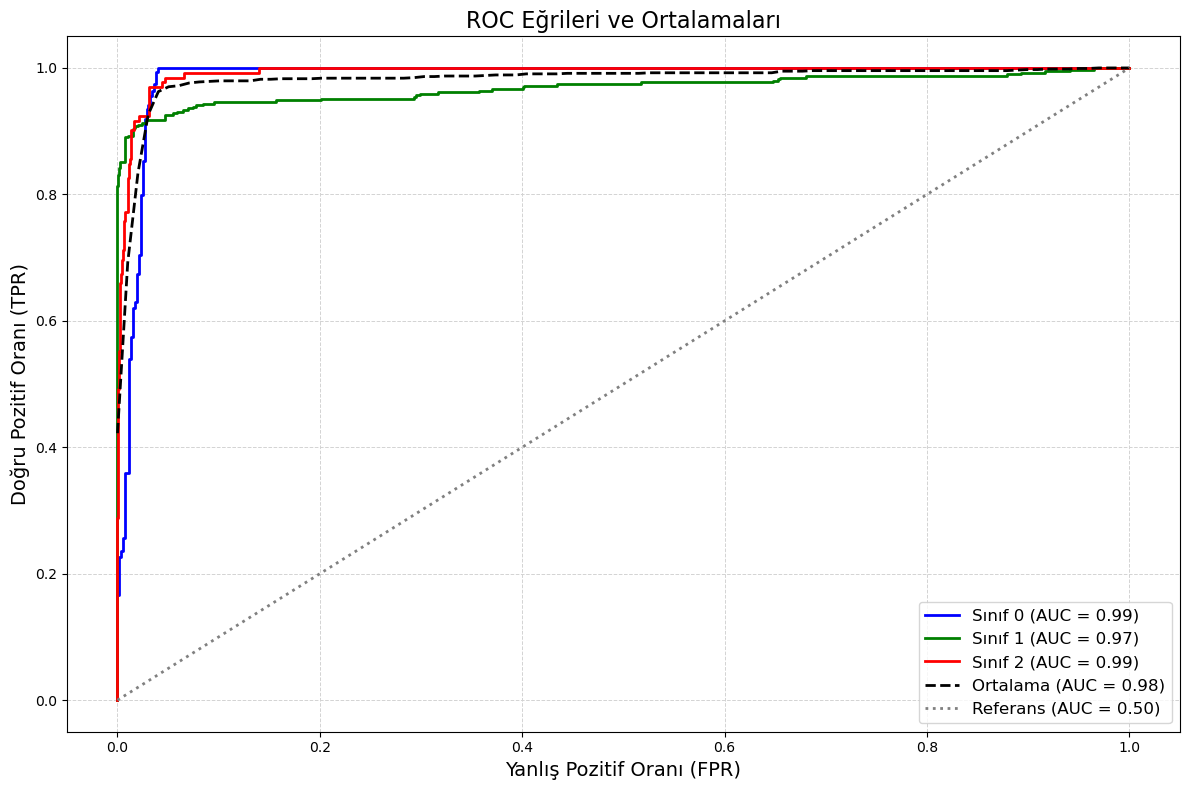

In [5]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

val_logits = trainer.predict(val_dataset).predictions
val_probabilities = torch.nn.functional.softmax(torch.tensor(val_logits), dim=-1).numpy() 
val_labels = val_dataset['labels']
val_labels = torch.tensor(val_labels).numpy()  

plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']  
mean_tpr = 0.0  
mean_fpr = np.linspace(0, 1, 100)  

for i in range(val_probabilities.shape[1]):  
    fpr, tpr, _ = roc_curve((val_labels == i).astype(int), val_probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f'Sınıf {i} (AUC = {roc_auc:.2f})')
    mean_tpr += np.interp(mean_fpr, fpr, tpr) 

mean_tpr /= val_probabilities.shape[1]
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', lw=2,
         label=f'Ortalama (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle=':', lw=2, label="Referans (AUC = 0.50)")

plt.title("ROC Eğrileri ve Ortalamaları", fontsize=16)
plt.xlabel("Yanlış Pozitif Oranı (FPR)", fontsize=14)
plt.ylabel("Doğru Pozitif Oranı (TPR)", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


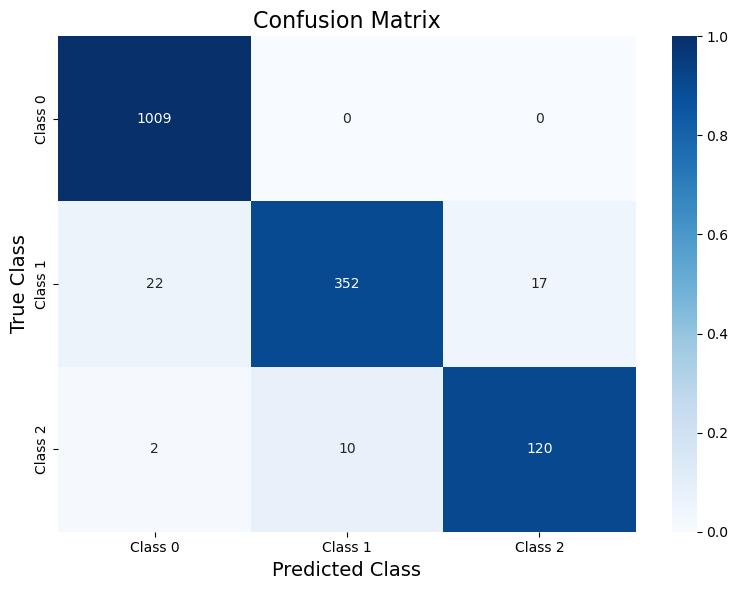

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_labels, val_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

class_names = [f"Class {i}" for i in range(cm.shape[0])]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=cm, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.tight_layout()
plt.show()


In [24]:
import time

start_time = time.time()
trainer.train()
training_time = time.time() - start_time

print(f"Training Time: {training_time:.2f} seconds")

start_time = time.time()
predictions = trainer.predict(val_dataset)
inference_time = time.time() - start_time

print(f"Inference Time: {inference_time:.2f} seconds")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Sensitivity,Specificity
1,0.144900,0.188293,0.965405,0.965831,0.965405,0.965071,nan,0.940860,1.000000
2,0.096000,0.208867,0.964099,0.964736,0.964099,0.963784,nan,0.940541,1.000000


Training Time: 207.40 seconds


Inference Time: 3.71 seconds


In [40]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from datasets import Dataset
from evaluate import load
import pandas as pd
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

file_path = "combined_all_news.csv" 
df = pd.read_csv(file_path)

class_counts = df['Sentiment_Label'].value_counts()
print("Sınıf Dağılımı:", class_counts)

class_weights = torch.tensor(1.0 / class_counts).to(device)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['İçerik Stemmed'].tolist(),
    df['Sentiment_Label'].tolist(),
    test_size=0.2,
    stratify=df['Sentiment_Label']
)

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(set(df['Sentiment_Label'])),
)

metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    labels = torch.tensor(labels).numpy()
    precision = precision_score(labels, predictions, average="weighted", zero_division=0)
    recall = recall_score(labels, predictions, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")
    try:
        auc = roc_auc_score(labels, logits, multi_class="ovr")
    except ValueError:
        auc = float('nan')
    cm = confusion_matrix(labels, predictions)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if len(cm) > 1 else 0
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if len(cm) > 1 else 0
    return {
        "accuracy": metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "sensitivity": sensitivity,
        "specificity": specificity
    }

training_args = TrainingArguments(
    output_dir="./results",                
    evaluation_strategy="epoch",          
    per_device_train_batch_size=16,       
    per_device_eval_batch_size=16,
    learning_rate=3e-5,                  
    num_train_epochs=5,                   
    weight_decay=0.01,                     
    save_strategy="epoch",               
    logging_strategy="epoch",            
    fp16=True,                             
    load_best_model_at_end=True,           
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  
)

trainer.train()

model.save_pretrained("distilbert_model")
tokenizer.save_pretrained("distilbert_model")
print("Model ve tokenizer başarıyla kaydedildi!")

eval_results = trainer.evaluate()
print(f"Değerlendirme Sonuçları:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

val_logits = trainer.predict(val_dataset).predictions
val_predictions = torch.argmax(torch.tensor(val_logits), dim=-1).numpy()

val_df = pd.DataFrame({
    "Text": val_texts,
    "Actual Sentiment": val_labels,
    "Predicted Sentiment": val_predictions
})

val_df.to_csv("predictions_distilbert.csv", index=False)
print("Tahminler 'predictions_distilbert.csv' dosyasına kaydedildi.")


Using device: cuda
Sınıf Dağılımı: Sentiment_Label
0    4949
1    1985
2     722
Name: count, dtype: int64


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\musta\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Sensitivity,Specificity
1,0.217200,0.178594,0.947781,0.956760,0.947781,0.948113,nan,0.938776,1.000000
2,0.128900,0.139348,0.969321,0.969733,0.969321,0.969023,nan,0.944882,1.000000
3,0.097500,0.139471,0.968668,0.968803,0.968668,0.968625,nan,0.965879,0.990909
4,0.079600,0.137048,0.967363,0.967469,0.967363,0.967014,nan,0.944882,1.000000
5,0.069900,0.132693,0.971932,0.971712,0.971932,0.971754,nan,0.963731,0.994949


Model ve tokenizer başarıyla kaydedildi!


Değerlendirme Sonuçları:
eval_loss: 0.1326933056116104
eval_accuracy: 0.9719321148825065
eval_precision: 0.9717115860060707
eval_recall: 0.9719321148825065
eval_f1: 0.9717544580196419
eval_auc: nan
eval_sensitivity: 0.9637305699481865
eval_specificity: 0.9949494949494949
eval_runtime: 2.1904
eval_samples_per_second: 699.431
eval_steps_per_second: 43.829
epoch: 5.0
Tahminler 'predictions_distilbert.csv' dosyasına kaydedildi.


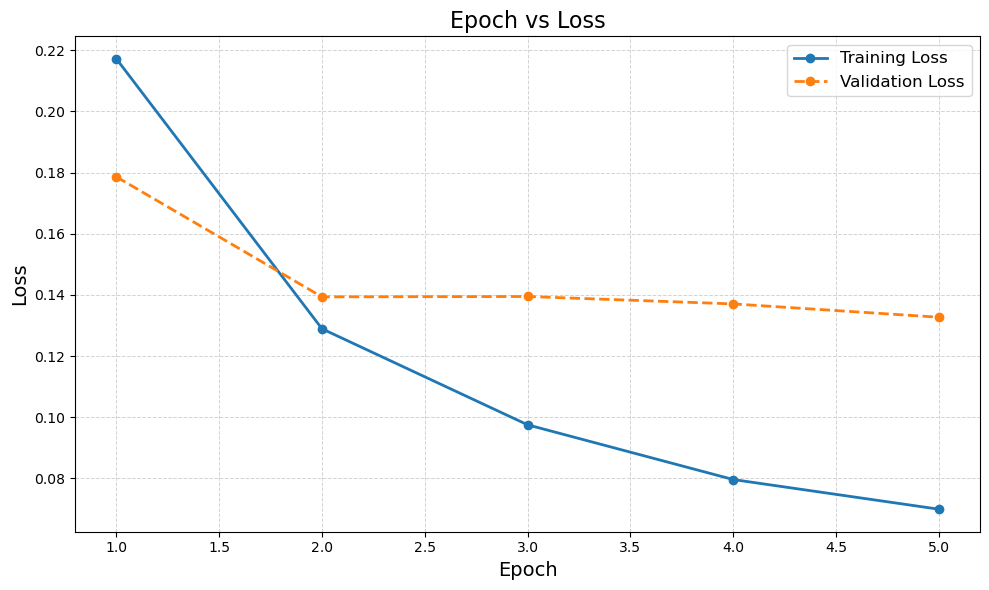

In [42]:
import matplotlib.pyplot as plt

training_logs = trainer.state.log_history

epochs = []
train_losses = []
eval_losses = []

for log in training_logs:
    if "epoch" in log:
        epochs.append(log["epoch"])
    if "loss" in log:  
        train_losses.append(log["loss"])
    if "eval_loss" in log:  
        eval_losses.append(log["eval_loss"])

min_length = min(len(train_losses), len(eval_losses))
train_losses = train_losses[:min_length]
eval_losses = eval_losses[:min_length]
epochs = range(1, min_length + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker='o', linestyle='-', linewidth=2)
plt.plot(epochs, eval_losses, label="Validation Loss", marker='o', linestyle='--', linewidth=2)

plt.title("Epoch vs Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


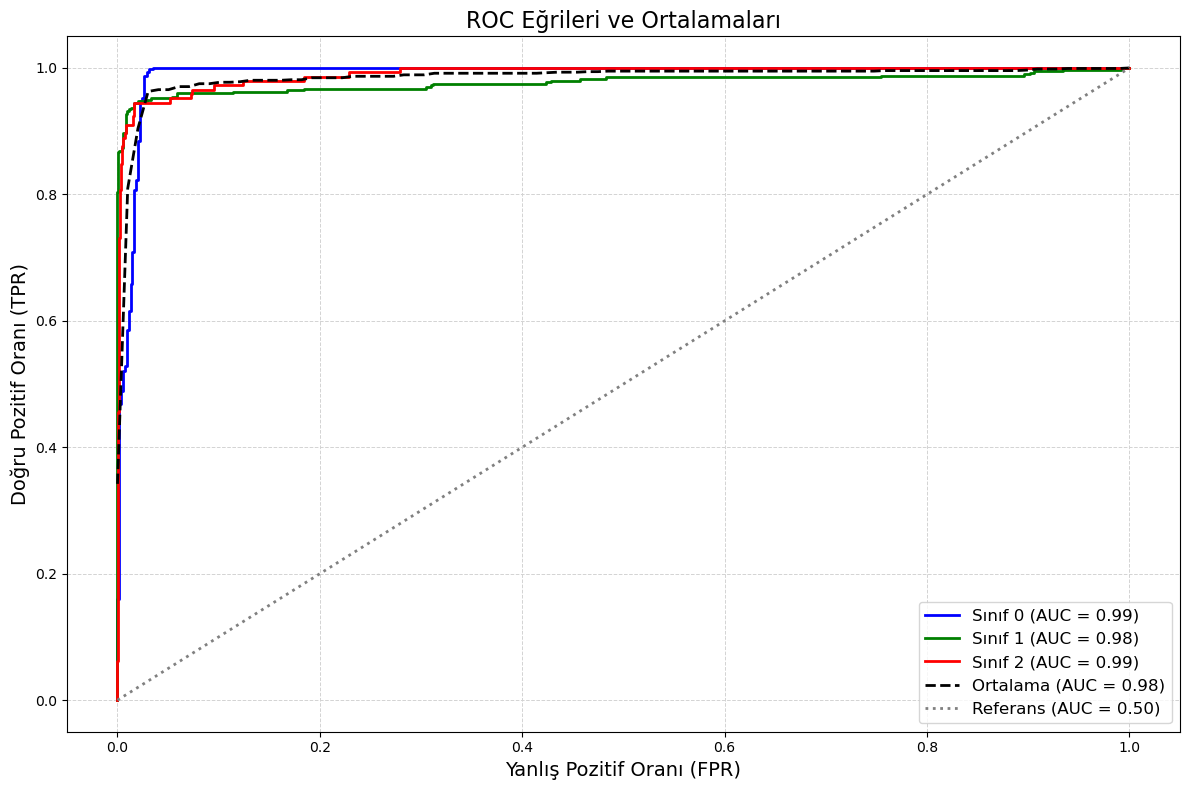

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch

val_logits = trainer.predict(val_dataset).predictions
val_probabilities = torch.nn.functional.softmax(torch.tensor(val_logits), dim=-1).numpy()  
val_labels = val_dataset['labels']
val_labels = torch.tensor(val_labels).numpy()  

plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']  
mean_tpr = 0.0  
mean_fpr = np.linspace(0, 1, 100)  

for i in range(val_probabilities.shape[1]):  
    fpr, tpr, _ = roc_curve((val_labels == i).astype(int), val_probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f'Sınıf {i} (AUC = {roc_auc:.2f})')
    mean_tpr += np.interp(mean_fpr, fpr, tpr)  

mean_tpr /= val_probabilities.shape[1]
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', lw=2,
         label=f'Ortalama (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle=':', lw=2, label="Referans (AUC = 0.50)")

plt.title("ROC Eğrileri ve Ortalamaları", fontsize=16)
plt.xlabel("Yanlış Pozitif Oranı (FPR)", fontsize=14)
plt.ylabel("Doğru Pozitif Oranı (TPR)", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


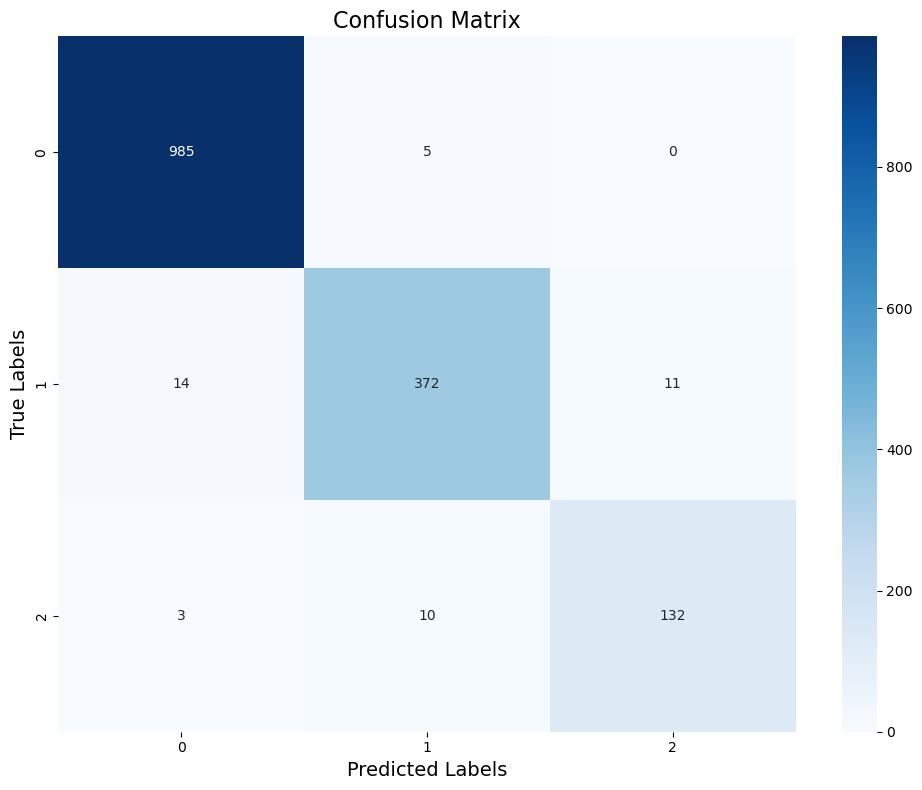

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(val_labels, val_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(set(val_labels))), yticklabels=range(len(set(val_labels))))
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.tight_layout()
plt.show()


In [48]:
import time

start_time = time.time()
trainer.train()
training_time = time.time() - start_time

print(f"Training Time: {training_time:.2f} seconds")

start_time = time.time()
predictions = trainer.predict(val_dataset)
inference_time = time.time() - start_time

print(f"Inference Time: {inference_time:.2f} seconds")


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Sensitivity,Specificity
1,0.083100,0.177421,0.966057,0.965751,0.966057,0.965589,nan,0.964010,0.993939
2,0.074000,0.170902,0.969974,0.969613,0.969974,0.969549,nan,0.948454,1.000000
3,0.052500,0.184057,0.966057,0.965786,0.966057,0.965875,nan,0.963731,0.989899
4,0.028800,0.200116,0.964752,0.964535,0.964752,0.964613,nan,0.958333,0.988889
5,0.011400,0.213733,0.962794,0.962461,0.962794,0.962561,nan,0.955959,0.988889


Training Time: 212.16 seconds


Inference Time: 2.04 seconds


In [5]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from datasets import Dataset
from evaluate import load
import pandas as pd
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

file_path = "combined_all_news.csv"  
df = pd.read_csv(file_path)

class_counts = df['Sentiment_Label'].value_counts()
print("Sınıf Dağılımı:", class_counts)

class_weights = torch.tensor(1.0 / class_counts).to(device)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['İçerik Stemmed'].tolist(),
    df['Sentiment_Label'].tolist(),
    test_size=0.2,
    stratify=df['Sentiment_Label']
)

tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")

def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})

model = BertForSequenceClassification.from_pretrained(
    "yiyanghkust/finbert-tone",
    num_labels=len(set(df['Sentiment_Label'])),
)

metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    labels = torch.tensor(labels).numpy()
    precision = precision_score(labels, predictions, average="weighted", zero_division=0)
    recall = recall_score(labels, predictions, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")
    try:
        auc = roc_auc_score(labels, logits, multi_class="ovr")
    except ValueError:
        auc = float('nan')
    cm = confusion_matrix(labels, predictions)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if len(cm) > 1 else 0
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if len(cm) > 1 else 0
    return {
        "accuracy": metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "sensitivity": sensitivity,
        "specificity": specificity
    }

training_args = TrainingArguments(
    output_dir="./results",               
    evaluation_strategy="epoch",        
    per_device_train_batch_size=16,       
    per_device_eval_batch_size=16,
    learning_rate=3e-5,                   
    num_train_epochs=3,                   
    weight_decay=0.01,                   
    save_strategy="epoch",               
    logging_strategy="epoch",            
    fp16=True,                            
    load_best_model_at_end=True,           
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

model.save_pretrained("finbert_model")
tokenizer.save_pretrained("finbert_model")
print("Model ve tokenizer başarıyla kaydedildi!")

eval_results = trainer.evaluate()
print(f"Değerlendirme Sonuçları:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

val_logits = trainer.predict(val_dataset).predictions
val_predictions = torch.argmax(torch.tensor(val_logits), dim=-1).numpy()

val_df = pd.DataFrame({
    "Text": val_texts,
    "Actual Sentiment": val_labels,
    "Predicted Sentiment": val_predictions
})

val_df.to_csv("predictions_finbert.csv", index=False)
print("Tahminler 'predictions_finbert.csv' dosyasına kaydedildi.")

Using device: cuda
Sınıf Dağılımı: Sentiment_Label
0    4949
1    1985
2     722
Name: count, dtype: int64


C:\Users\musta\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Sensitivity,Specificity
1,0.227000,0.122323,0.970627,0.971957,0.970627,0.970590,nan,0.960000,0.996970
2,0.109700,0.104282,0.976501,0.976377,0.976501,0.976378,nan,0.964010,0.994949
3,0.069800,0.109070,0.977807,0.977686,0.977807,0.977645,nan,0.964377,0.995960


Model ve tokenizer başarıyla kaydedildi!


Değerlendirme Sonuçları:
eval_loss: 0.10907027870416641
eval_accuracy: 0.9778067885117493
eval_precision: 0.9776863880453358
eval_recall: 0.9778067885117493
eval_f1: 0.9776450900463562
eval_auc: nan
eval_sensitivity: 0.9643765903307888
eval_specificity: 0.9959595959595959
eval_runtime: 3.1567
eval_samples_per_second: 485.315
eval_steps_per_second: 30.411
epoch: 3.0
Tahminler 'predictions_finbert.csv' dosyasına kaydedildi.


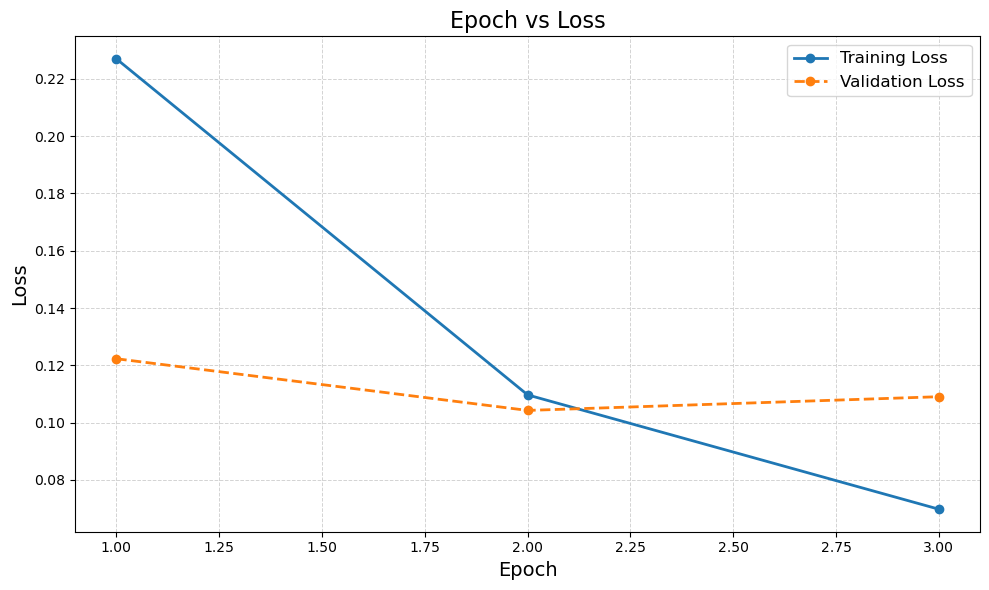

In [7]:
import matplotlib.pyplot as plt

training_logs = trainer.state.log_history

epochs = []
train_losses = []
eval_losses = []

for log in training_logs:
    if "epoch" in log:
        epochs.append(log["epoch"])
    if "loss" in log:  
        train_losses.append(log["loss"])
    if "eval_loss" in log:  
        eval_losses.append(log["eval_loss"])

min_length = min(len(train_losses), len(eval_losses))
train_losses = train_losses[:min_length]
eval_losses = eval_losses[:min_length]
epochs = range(1, min_length + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker='o', linestyle='-', linewidth=2)
plt.plot(epochs, eval_losses, label="Validation Loss", marker='o', linestyle='--', linewidth=2)

plt.title("Epoch vs Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


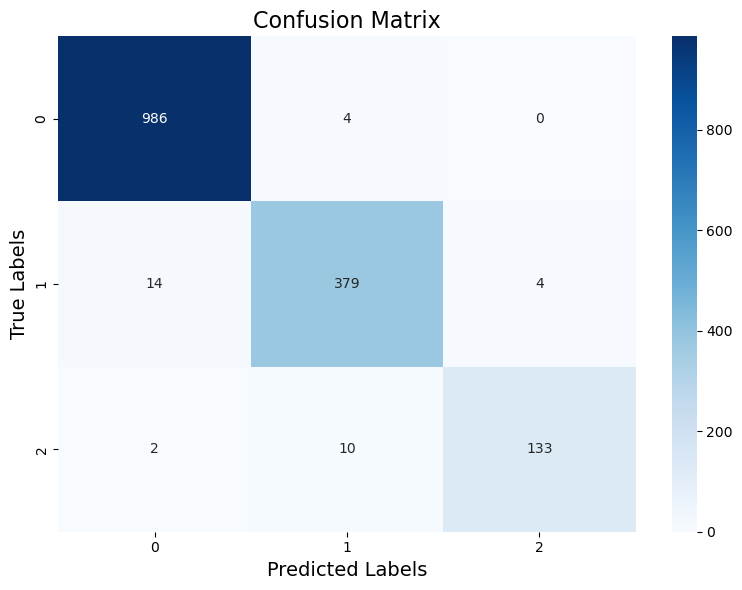

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels = val_labels
predicted_labels = val_predictions

cm = confusion_matrix(true_labels, predicted_labels)
cm_labels = list(set(true_labels))  

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.tight_layout()
plt.show()


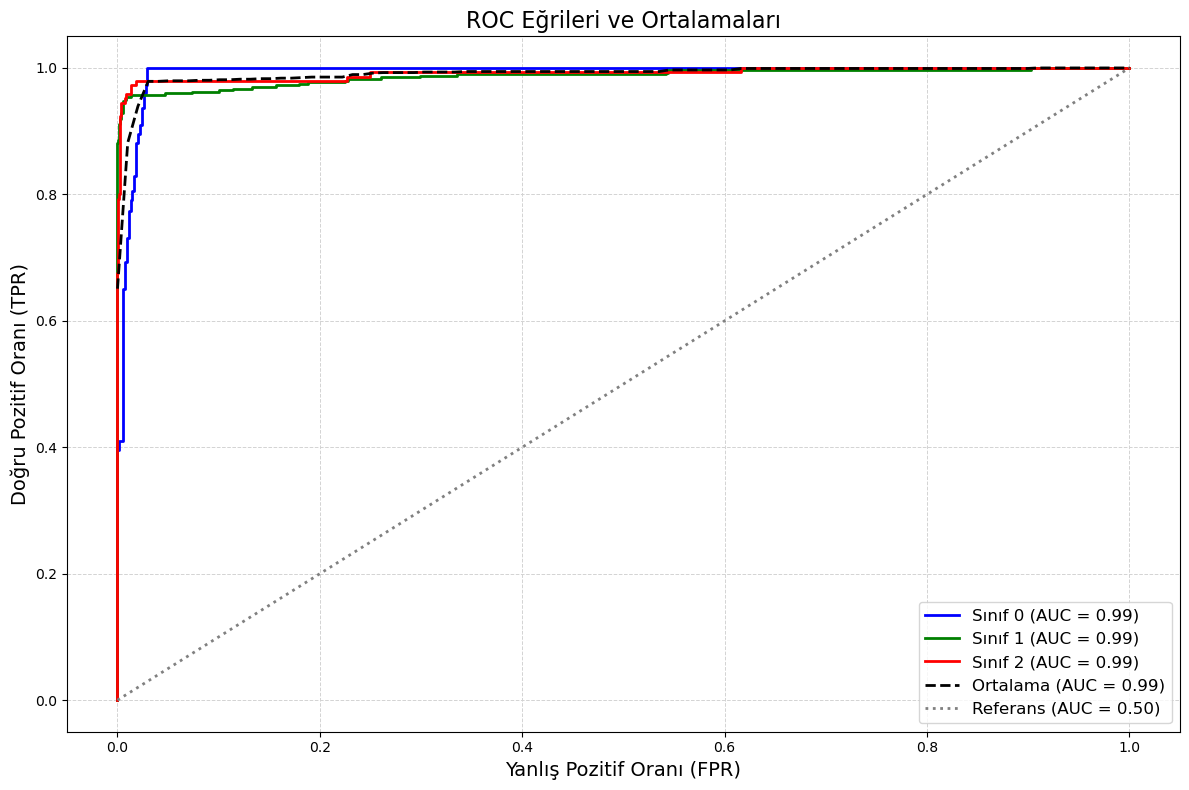

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch

val_logits = trainer.predict(val_dataset).predictions
val_probabilities = torch.nn.functional.softmax(torch.tensor(val_logits), dim=-1).numpy()  
val_labels = val_dataset['labels']
val_labels = torch.tensor(val_labels).numpy()  

plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']  
mean_tpr = 0.0 
mean_fpr = np.linspace(0, 1, 100) 

for i in range(val_probabilities.shape[1]): 
    fpr, tpr, _ = roc_curve((val_labels == i).astype(int), val_probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f'Sınıf {i} (AUC = {roc_auc:.2f})')
    mean_tpr += np.interp(mean_fpr, fpr, tpr)  

mean_tpr /= val_probabilities.shape[1]
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', lw=2,
         label=f'Ortalama (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle=':', lw=2, label="Referans (AUC = 0.50)")

plt.title("ROC Eğrileri ve Ortalamaları", fontsize=16)
plt.xlabel("Yanlış Pozitif Oranı (FPR)", fontsize=14)
plt.ylabel("Doğru Pozitif Oranı (TPR)", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


In [13]:
import time

start_time = time.time()
trainer.train()
training_time = time.time() - start_time

print(f"Training Time: {training_time:.2f} seconds")

start_time = time.time()
predictions = trainer.predict(val_dataset)
inference_time = time.time() - start_time

print(f"Inference Time: {inference_time:.2f} seconds")


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Sensitivity,Specificity
1,0.096500,0.152916,0.967363,0.967060,0.967363,0.967077,nan,0.953964,0.993927
2,0.064700,0.155150,0.975196,0.975181,0.975196,0.975065,nan,0.961240,0.994949
3,0.026900,0.186878,0.972585,0.972398,0.972585,0.972405,nan,0.956522,0.992929


Training Time: 213.82 seconds


Inference Time: 3.11 seconds
